### predict bike trip duration with BigQuery ML

### Feature Engineering

In [ ]:
SELECT
start_station_name,
AVG(duration) AS duration
FROM
`bigquery-public-data`.london_bicycles.cycle_hire
GROUP BY
start_station_name

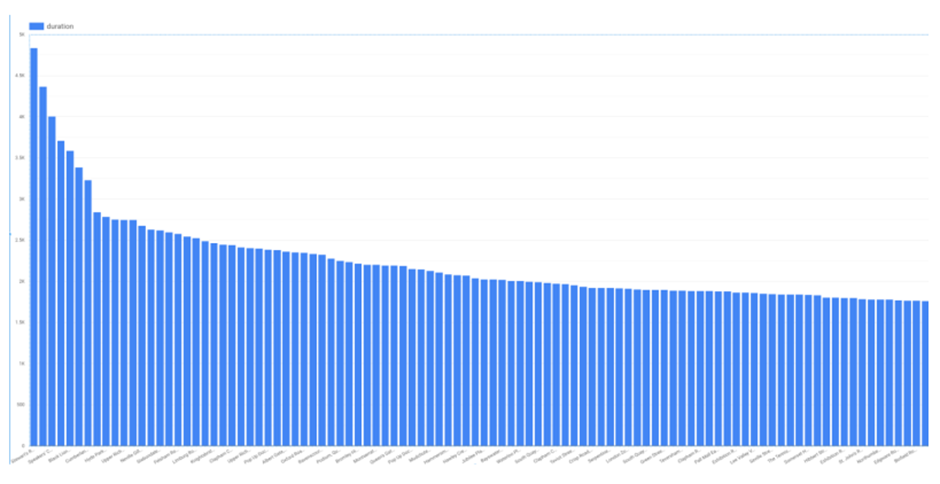

stations are associated with long-duration rentals

Note that we cannot use end_station_name as a feature because at the time the bicycle is 
being rented, we won’t know where the bicycle is going to be returned to. Because we are 
creating a machine learning model to predict events in the future, we need to be mindful of 
not using any columns that will not be known at the time the prediction is made. This 
time/causality criterion imposes constraints on what features we can use


#### Impact of day of week and hour of day

In [ ]:
SELECT
EXTRACT(dayofweek
FROM
start_date) AS dayofweek,
AVG(duration) AS duration
FROM
`bigquery-public-data`.london_bicycles.cycle_hire
GROUP BY
dayofweek



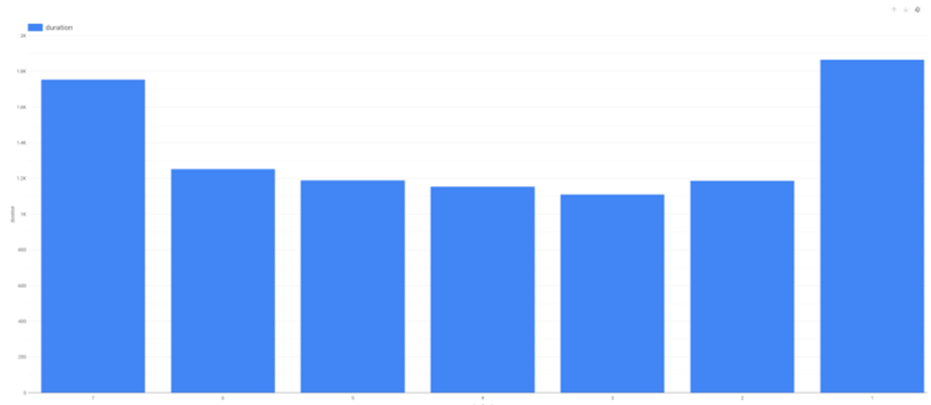

For hour of day your visualization should look like the following:

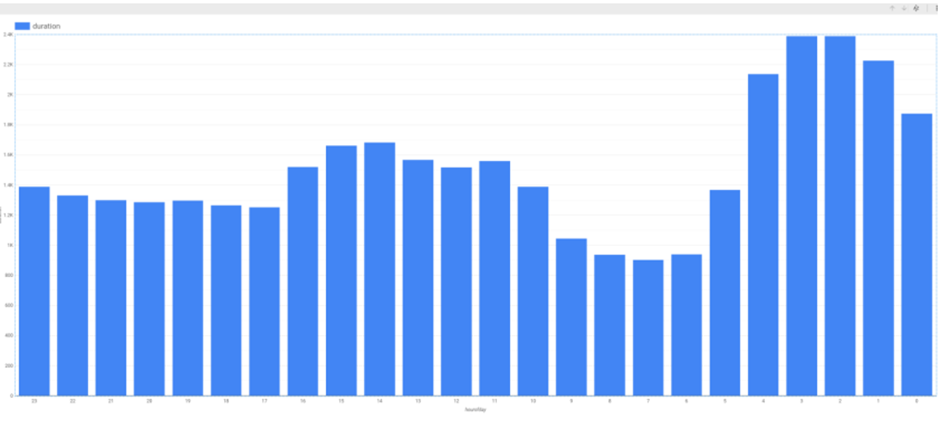

#### Impact of number of bicycles


In [ ]:
SELECT
bikes_count,
AVG(duration) AS duration
FROM
`bigquery-public-data`.london_bicycles.cycle_hire
JOIN
`bigquery-public-data`.london_bicycles.cycle_stations
ON
cycle_hire.start_station_name = cycle_stations.name
GROUP BY
bikes_count


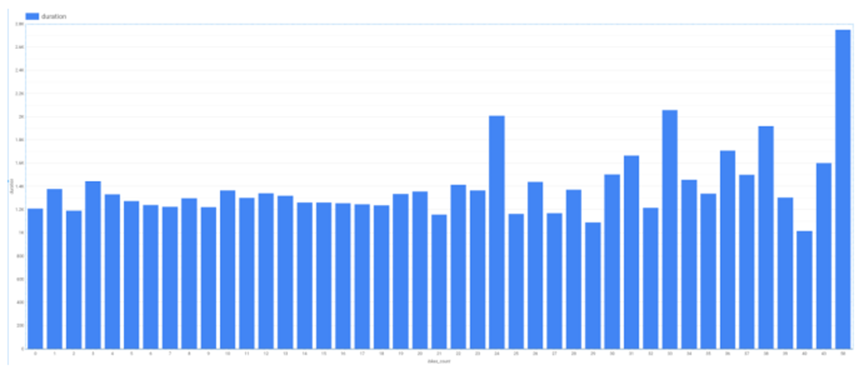

#### Create a training dataset


In [ ]:
SELECT
duration,
start_station_name,
CAST(EXTRACT(dayofweek
FROM
start_date) AS STRING) AS dayofweek,
CAST(EXTRACT(hour
FROM
start_date) AS STRING) AS hourofday
FROM
`bigquery-public-data`.london_bicycles.cycle_hire

###  training and evaluation data

In [ ]:
CREATE OR REPLACE MODEL
bike_model.model
OPTIONS
(input_label_cols=['duration'],
model_type='linear_reg') AS
SELECT
duration,
start_station_name,
CAST(EXTRACT(dayofweek
FROM
start_date) AS STRING) AS dayofweek,
CAST(EXTRACT(hour
FROM
start_date) AS STRING) AS hourofday
FROM
`bigquery-public-data`.london_bicycles.cycle_hire

In [ ]:
SELECT * FROM ML.EVALUATE(MODEL `bike_model.model`)

### Improving the model through feature engineering

In [ ]:
CREATE OR REPLACE MODEL
bike_model.model_weekday
OPTIONS
(input_label_cols=['duration'],
model_type='linear_reg') AS
SELECT
duration,
start_station_name,
IF
(EXTRACT(dayofweek
FROM
start_date) BETWEEN 2 AND 6,
'weekday',
'weekend') AS dayofweek,
CAST(EXTRACT(hour
FROM
start_date) AS STRING) AS hourofday
FROM
`bigquery-public-data`.london_bicycles.cycle_hire

In [ ]:
SELECT * FROM ML.EVALUATE(MODEL `bike_model.model_weekday`)

This model results in a mean absolute error of 966 seconds which is less than the 1025 seconds for the original 
model. Improvement!

### Bucketize hour of day
Based on the relationship between hourofday and the duration, we can experiment with bucketizing the variable into 4 
bins; (-inf,5), [5,10), [10,17), and [17,inf).

In [ ]:
CREATE OR REPLACE MODEL
bike_model.model_bucketized
OPTIONS
(input_label_cols=['duration'],
model_type='linear_reg') AS
SELECT
duration,
start_station_name,
IF
(EXTRACT(dayofweek
FROM
start_date) BETWEEN 2 AND 6,
'weekday',
'weekend') AS dayofweek,
ML.BUCKETIZE(EXTRACT(hour
FROM
start_date),
[5, 10, 17]) AS hourofday
FROM
`bigquery-public-data`.london_bicycles.cycle_hire
SELECT * FROM ML.EVALUATE(MODEL 
`bike_model.model_bucketized`)

This model results in a mean absolute error of 904 
seconds which is less than the 966 seconds for the 
weekday-weekend model. Further improvement!

### Make predictions
Our best model contains several data transformations. Wouldn’t it be nice if BigQuery could remember the sets of 
transformations we did at the time of training and automatically apply them at the time of prediction? It can, using 
the TRANSFORM clause!
In this case, the resulting model requires just the start_station_name and start_date to predict the duration. The 
transformations are saved and carried out on the provided raw data to create input features for the model. The main 
advantage of placing all preprocessing functions inside the TRANSFORM clause is that clients of the model do not 
have to know what kind of preprocessing has been carried out.
1.Build a BigQuery ML model with the TRANSFORM clause that incorporates the bucketized hour of day, and combined 
days of week features using the query below:


In [ ]:
CREATE OR REPLACE MODEL
bike_model.model_bucketized TRANSFORM(* 
EXCEPT(start_date),
IF
(EXTRACT(dayofweek
FROM
start_date) BETWEEN 2 AND 6,
'weekday',
'weekend') AS dayofweek,
ML.BUCKETIZE(EXTRACT(HOUR
FROM
start_date),
[5, 10, 17]) AS hourofday )

In [ ]:
-- 2.With the TRANSFORM clause in place, enter this query to predict the duration of a rental from Park Lane 
-- right now (your result will vary):
SELECT
*
FROM
ML.PREDICT(MODEL bike_model.model_bucketized,
(
SELECT
'Park Lane , Hyde Park' AS start_station_name,
CURRENT_TIMESTAMP() AS start_date) )


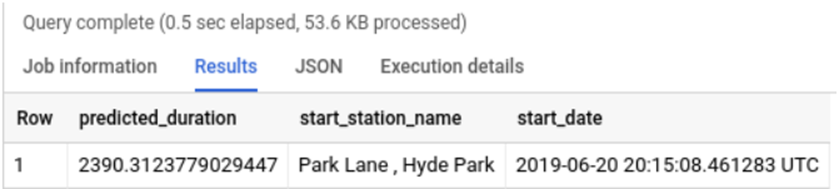

In [ ]:
-- 3.To make batch predictions on a sample of 100 rows in the training set use the query:

SELECT
*
FROM
ML.PREDICT(MODEL bike_model.model_bucketized,
(
SELECT
start_station_name,
start_date
FROM
`bigquery-public-data`.london_bicycles.cycle_hire
LIMIT
100) )


### Examine model weights

In [ ]:
SELECT * FROM ML.WEIGHTS(MODEL bike_model.model_bucketized)

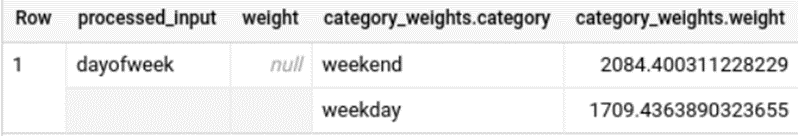